In [6]:
import os
import sys
import math
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')

from dotenv import load_dotenv
load_dotenv()

from sklearn.metrics import mutual_info_score, mean_absolute_error, mean_squared_error

from sqlalchemy import create_engine
from database.queries import get_game_stats

import arviz as az
import bambi as bmb

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', 100)

In [2]:
# loading up the postgres credentials
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
database = os.getenv('DB_NAME')
port = os.getenv('DB_PORT')

# # creating the URI for the database
URI = f'postgresql://{user}:{password}@{host}:{port}/{database}'

# # establishing a connection to the database
engine = create_engine(URI)

In [3]:
lee_sharpe_query = """
    select *
    from lee_sharpe
    where season >= 2000 and game_type = 'REG'
"""

ls = pd.read_sql(lee_sharpe_query, URI)

In [4]:
stadium_query = """
    select *
    from stadium_locations
"""

# loading the stadium data and cleaning it up
stadia_df = pd.read_sql(stadium_query, URI)
stadia_df.drop_duplicates(subset='stadium', inplace=True)
stadia_df['stadium'] = stadia_df['stadium'].str.strip()

# a dictionary to map names
stadium_dict = {
    'Hubert H. Humphrey Metrodome' : 'Hubert H Humphrey Metrodome',
    'Foxboro Stadium' : 'Foxboro',
    'Veterans Stadium' : 'Nassau Veterans Memorial Coliseum',
    '3Com Park' : 'Candlestick Park'
}

ls['stadium'] = ls['stadium'].map(stadium_dict).fillna(ls['stadium'])

In [5]:
ls.head()

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,2000_01_ARI_NYG,2000,REG,1,2000-09-03,Sunday,13:00,ARI,16,NYG,21,Home,5,37,0,2000090300,987.0,None,200009030nyg,NaN,200903019,7,7,NaN,NaN,6.5,NaN,NaN,40.0,NaN,NaN,1,outdoors,grass,80.0,3.0,00-0013042,00-0003292,Jake Plummer,Kerry Collins,Vince Tobin,Jim Fassel,Bill Carollo,NYC00,Giants Stadium
1,2000_01_BAL_PIT,2000,REG,1,2000-09-03,Sunday,13:00,BAL,16,PIT,0,Home,-16,16,0,2000090301,988.0,None,200009030pit,NaN,200903023,7,7,NaN,NaN,-2.5,NaN,NaN,37.0,NaN,NaN,1,outdoors,astroturf,74.0,8.0,00-0000722,00-0006212,Tony Banks,Kent Graham,Brian Billick,Bill Cowher,Phil Luckett,PIT99,Three Rivers Stadium
2,2000_01_CAR_WAS,2000,REG,1,2000-09-03,Sunday,13:00,CAR,17,WAS,20,Home,3,37,0,2000090302,990.0,None,200009030was,NaN,200903028,7,7,NaN,NaN,10.5,NaN,NaN,47.5,NaN,NaN,0,outdoors,grass,80.0,0.0,00-0001218,00-0008442,Steve Beuerlein,Brad Johnson,George Seifert,Norv Turner,Bob McElwee,WAS00,FedExField
3,2000_01_CHI_MIN,2000,REG,1,2000-09-03,Sunday,13:00,CHI,27,MIN,30,Home,3,57,0,2000090303,991.0,None,200009030min,NaN,200903016,7,7,NaN,NaN,4.5,NaN,NaN,46.5,NaN,NaN,1,dome,astroturf,NaN,NaN,00-0011044,00-0003739,Cade McNown,Daunte Culpepper,Dick Jauron,Dennis Green,Ed Hochuli,MIN00,Hubert H Humphrey Metrodome
4,2000_01_DEN_STL,2000,REG,1,2000-09-04,Monday,09:00,DEN,36,STL,41,Home,5,77,0,2000090400,1002.0,None,200009040ram,NaN,200904014,7,7,NaN,NaN,6.5,NaN,NaN,48.5,NaN,NaN,0,dome,astroturf,NaN,NaN,00-0006423,00-0017200,Brian Griese,Kurt Warner,Mike Shanahan,Mike Martz,Gerry Austin,STL00,TWA Dome


In [6]:
# merging lee sharpe's data with the stadium locations
ls = ls.merge(stadia_df, how='left', on='stadium')

In [7]:
# fixing referees
ref_dict = {'Adrian Hall' : 'Adrian Hill',
            'Bill Vinocich' : 'Bill Vinovich',
            'Gene Stetatore' : 'Gene Steratore',
            'John Perry' : 'John Parry', 
            }
ls['referee'] = ls['referee'].map(ref_dict).fillna(ls['referee'])

In [8]:
# getting the final regular season results for each team for
# each season in the data set
ls['home_win'] = ls['home_score'] > ls['away_score']
ls['away_win'] = ls['away_score'] > ls['home_score']
ls['tie'] = ls['home_score'] == ls['away_score']

home_wins = ls.groupby(['season', 'home_team'])[['home_win', 'tie']].sum().reset_index()
away_wins = ls.groupby(['season', 'away_team'])[['away_win', 'tie']].sum().reset_index()

final_results = (
    home_wins
    .merge(away_wins, left_on=['season', 'home_team'], right_on=['season', 'away_team'])
    .rename(columns={'home_team' : 'team', 'tie_x' : 'ties'})
    .assign(total_wins=lambda x: x['home_win'] + x['away_win'],
            total_ties=lambda x: x['ties'] + x['tie_y'])
    .drop(columns=['home_win', 'ties', 'away_team', 'away_win', 'tie_y'])
)

final_results['total_losses'] = (
    np.where(final_results['season'] < 2021,
             16 - final_results['total_wins'] + final_results['total_ties'],
             17 - final_results['total_wins'] + final_results['total_ties']
            )
)

In [9]:
# getting the coaches for each team for each season (curiosity)
coach_dict = ls.groupby(['season', 'home_team'])['home_coach'].unique().to_dict()
final_results['coaches'] = [coach_dict[(x, y)] for x, y in zip(final_results.season, final_results.team)]

In [10]:
# rearranging the data so its easier to put into a model
# i've done this in different ways, but this time i'm going 
# to do it straightforwardly one line at a time

# creating a home dataframe
df_home = pd.DataFrame()
df_home['game_id'] = ls['game_id']
df_home['season'] = ls['season']
df_home['team_a'] = ls['home_team']
df_home['team_b'] = ls['away_team']
df_home['team_a_home'] = 1
df_home['team_a_score'] = ls['home_score']
df_home['team_b_score'] = ls['away_score']
df_home['team_a_coach'] = ls['home_coach']
df_home['team_b_coach'] = ls['away_coach']
df_home['team_a_rest'] = ls['home_rest']
df_home['team_b_rest'] = ls['away_rest']
df_home['team_a_rest_edge'] = df_home['team_a_rest'].sub(df_home['team_b_rest'])
df_home['total_line'] = ls['total_line']
df_home['total_score'] = df_home['team_a_score'].add(df_home['team_b_score'])
df_home['spread_line'] = ls['spread_line'] * -1
df_home['referee'] = ls['referee']
df_home['week'] = [int(x.split('_')[1]) for x in ls['game_id'].values]
df_home['stadium'] = ls['stadium']
df_home['stadium_lat'] = ls['lat']
df_home['stadium_long'] = ls['long']

# creating an away dataframe
df_away = pd.DataFrame()
df_away['game_id'] = ls['game_id']
df_away['season'] = ls['season']
df_away['team_a'] = ls['away_team']
df_away['team_b'] = ls['home_team']
df_away['team_a_home'] = 0
df_away['team_a_score'] = ls['away_score']
df_away['team_b_score'] = ls['home_score']
df_away['team_a_coach'] = ls['away_coach']
df_away['team_b_coach'] = ls['home_coach']
df_away['team_a_rest'] = ls['away_rest']
df_away['team_b_rest'] = ls['home_rest']
df_away['team_a_rest_edge'] = df_away['team_a_rest'].sub(df_away['team_b_rest'])
df_away['total_line'] = ls['total_line']
df_away['total_score'] = df_away['team_a_score'].add(df_away['team_b_score'])
df_away['spread_line'] = ls['spread_line']
df_away['referee'] = ls['referee']
df_away['week'] = [int(x.split('_')[1]) for x in ls['game_id'].values]
df_away['stadium'] = ls['stadium']
df_away['stadium_lat'] = ls['lat']
df_away['stadium_long'] = ls['long']

df_combined = pd.concat([df_home, df_away])
df_combined = df_combined.sort_values(by='game_id').reset_index(drop=True)

# creating a win or loss target for the combined dataframe
df_combined['team_a_win'] = (df_combined['team_a_score'] > df_combined['team_b_score']).astype(int)

# creating a margin of victory target for the combined dataframe
df_combined['team_a_mov'] = df_combined['team_a_score'] - df_combined['team_b_score']

In [11]:
def haversine(season, team, lat2, lon2):
    
    "calculates the distance from a home stadium to game stadium"
    
    lat1 = dict_coords[(season, team)][0]
    lon1 = dict_coords[(season, team)][1]
    
    r = 6371  
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    res = r * (2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))
    return res

In [12]:
# getting home stadiums for each season in order to calculate
# the distance to road games and the length of road trips

home_stadia = (
    df_home
    .groupby(['season', 'team_a'])[['stadium', 'stadium_lat', 'stadium_long']]
    .first()
    .reset_index()
)

home_stadia['stadium'] = (
    np.where(home_stadia['stadium'] == 'Wembley Stadium',
             'Hard Rock Stadium',
             home_stadia['stadium'])
)

home_stadia['stadium_lat'] = (
    np.where(home_stadia['stadium'] == 'Hard Rock Stadium',
             25.95796,
             home_stadia['stadium_lat'])
)

home_stadia['stadium_long'] = (
    np.where(home_stadia['stadium'] == 'Hard Rock Stadium',
             -80.239311,
             home_stadia['stadium_long'])
)


# creating a dictionary to simplify the mapping
home_stadia = home_stadia.set_index(['season', 'team_a'])
dict_coords = home_stadia[['stadium_lat', 'stadium_long']].apply(tuple, axis=1).to_dict()

# using the haversine function to get the actual distances
df_combined['team_a_distance_home'] = (
    df_combined
    .apply(lambda x: haversine(x['season'], x['team_a'], x['stadium_lat'], x['stadium_long']), axis=1)
)

df_combined['team_b_distance_home'] = (
    df_combined
    .apply(lambda x: haversine(x['season'], x['team_b'], x['stadium_lat'], x['stadium_long']), axis=1)
)

# removing any home indicator for games outside of north america
df_combined.loc[df_combined['team_a_distance_home'] >= 4400, 'team_a_home'] = 0

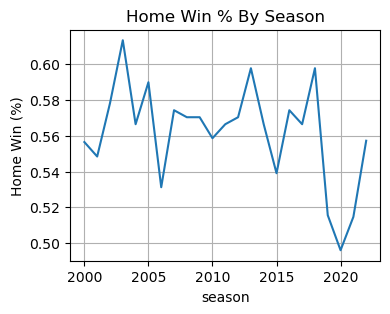

In [13]:
# getting home team win percentage - it includes neutral 
# fields, like tottenham and so on, but that doesnt 
# change the results - just want a feel for it
hfa_df = (
    df_combined
    .groupby(['season', 'team_a_home'])['team_a_win']
    .mean()
    .reset_index()
)

hfa_df = hfa_df[hfa_df['team_a_home'] == 1].copy()

fig, ax = plt.subplots(figsize=(4,3))
sns.lineplot(x='season', y='team_a_win', data=hfa_df)

plt.grid(True)
plt.title('Home Win % By Season')
plt.ylabel("Home Win (%)")
plt.show()

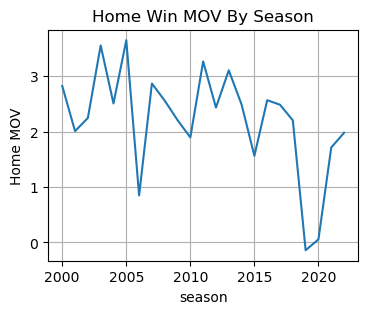

In [14]:
df_home['home_mov'] = df_home['team_a_score'] - df_home['team_b_score']

mov_df = (
    df_home
    .groupby('season')['home_mov']
    .mean()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(4,3))
sns.lineplot(x='season', y='home_mov', data=mov_df)

plt.grid(True)
plt.title('Home Win MOV By Season')
plt.ylabel("Home MOV")
plt.show()

# Estimating HFA by Season

Computing the mean value and standard error for each season.  
Since the seasons are treated independently, this is an 'unpooled'  
estimate. It will be slightly worse than using an estimate that  
pulls all of the values towards the grand mean.  

Afterwards, creating a model in Bambi that will estimate HFA  
for each season. Each season gets its own intercept drawn from  
a common distribution, in effect pulling each estimate towards  
the grand mean. 

In [280]:
# let's do the most obvious thing in the world and compute 
# the mean and standard error for each season

def standard_error(x):
    return np.std(x) / np.sqrt(len(x))

hfa_df = (
    df_home
    .groupby('season')['team_a_mov']
    .agg(mov_avg='mean', mov_se=standard_error)
    .assign(est_high=lambda x: x['mov_avg'] + (2 * x['mov_se']),
            est_low=lambda x: x['mov_avg'] - (2 * x['mov_se']))
)

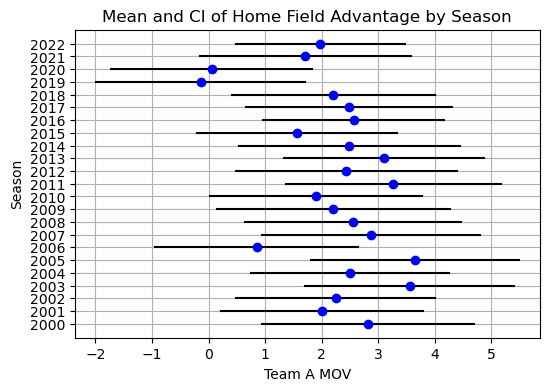

In [281]:
# plotting the mean and confidence intervals for each season's
# hfa

plt.figure(figsize=(6, 4))

# Create a mapping for each unique season to a unique y value
seasons = hfa_df.index.unique()
y_values = range(len(seasons))
season_to_y = {season: y for season, y in zip(seasons, y_values)}

# plotting each season's confidnece interval as a line with a point 
# in the middle for the mean
for season, row in hfa_df.iterrows():
    y = season_to_y[season]
    plt.plot([row['est_low'], row['est_high']], [y, y], color='black') 
    plt.plot(row['mov_avg'], y, 'bo') 

plt.yticks(y_values, seasons)
plt.xlabel('Team A MOV')
plt.ylabel('Season')
plt.title('Mean and CI of Home Field Advantage by Season')
plt.grid(True)
plt.show()

In [147]:
# creating a simple model to predict whether team_a wins 
# using only home field status and season
home_model = bmb.Model('team_a_mov ~ 0 + (1 | season)', data=df_home, dropna=True)
home_results = home_model.fit(draws=2000, chains=2, idata_kwargs=dict(log_likelihood = True))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [team_a_mov_sigma, 1|season_sigma, 1|season_offset]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


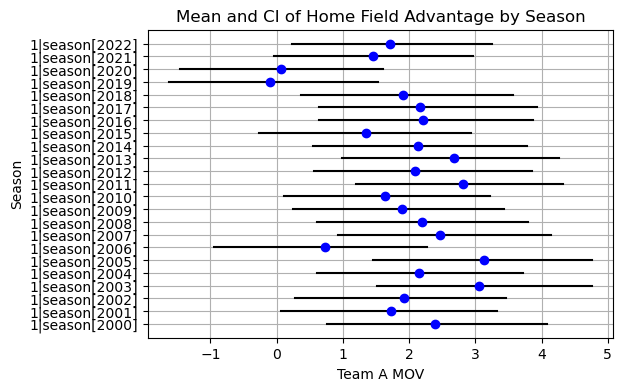

In [170]:
hfa_model_df = pd.DataFrame()

for idx, row in az.summary(home_results).iterrows():
    
    if '[' in idx:
        df_ = pd.DataFrame([row[['mean', 'hdi_3%', 'hdi_97%']]], index=[idx])
        hfa_model_df = pd.concat([hfa_model_df, df_])

        
# creating the very same plot as above for the modeled parameters
plt.figure(figsize=(6, 4))

seasons = hfa_model_df.index.unique()
y_values = range(len(seasons))
season_to_y = {season: y for season, y in zip(seasons, y_values)}

# plotting each season's CREDIBLE interval as a line with a point 
# in the middle for the mean
for season, row in hfa_model_df.iterrows():
    y = season_to_y[season]
    plt.plot([row['hdi_3%'], row['hdi_97%']], [y, y], color='black') 
    plt.plot(row['mean'], y, 'bo') 

plt.yticks(y_values, seasons)
plt.xlabel('Team A MOV')
plt.ylabel('Season')
plt.title('Mean and CI of Home Field Advantage by Season')
plt.grid(True)
plt.show()

# Creating a Model to Predict Team Points 

In [103]:
# creating a model to predict how many points team a 
# will score

priors = {'Intercept' : bmb.Prior("Normal", mu=1, sigma=1),
          'team_a_home' : bmb.Prior("Normal", mu=2, sigma=2),
          '1|week_sigma' : bmb.Prior("HalfNormal", sigma=12)
         }

model = bmb.Model('team_a_score ~ 1 + team_a_home + (1|week) + (1|season/team_a) + (1|season/team_b)', data=df_combined, priors=priors)
results = model.fit(draws=4000, chains=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [team_a_score_sigma, Intercept, team_a_home, 1|week_sigma, 1|week_offset, 1|season_sigma, 1|season_offset, 1|season:team_a_sigma, 1|season:team_a_offset, 1|season:team_b_sigma, 1|season:team_b_offset]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 1446 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [171]:
ml_model_results = az.summary(results)

In [71]:
mean_preds = model.predict(results, kind='mean', inplace=False)
pps_preds_test = model.predict(results, kind='pps', data=season_df_test, inplace=False)

season_df_test['preds'] = pd.DataFrame(pps_preds_test.posterior_predictive['team_a_score'][0]).mean().values
season_df_test['pred_total'] = season_df_test.groupby('game_id')['preds'].transform(lambda x: x.sum())

In [ ]:
# not a fair comparison of course, but we're on the right track at least

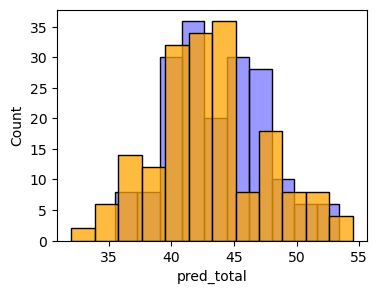

In [108]:
fig, ax = plt.subplots(figsize=(4,3))
sns.histplot(season_df_test['pred_total'], color='blue', alpha=0.4)
sns.histplot(season_df_test['total_line'], color='orange')
plt.show()

In [112]:
results_dict = {}

for idx, row in az.summary(results).iterrows():
    results_dict[idx] = [row['mean'], row['sd']]

In [284]:
season_df = pd.DataFrame()

for key in results_dict.keys():
    if '2022' in key:
        df_ = pd.DataFrame([results_dict[key]], index=[key])
        season_df = pd.concat([season_df, df_]) 

In [285]:
team_b = season_df[season_df.index.str.contains('team_b')]

team_b.index = [x.split(':')[-1].strip(']') for x in team_b.index]
team_b.columns = 'def_mean', 'def_sd'

team_a = season_df[season_df.index.str.contains('team_a')]
team_a.index = [x.split(':')[-1].strip(']') for x in team_a.index]
team_a.columns = ['off_mean', 'off_sd']

off_def_22 = team_a.join(team_b)

In [286]:
off_def_22['total_edge'] = off_def_22['off_mean'] + (off_def_22['def_mean'] * -1)


off_def_22.sort_values(by='total_edge', ascending=False)

,off_mean,off_sd,def_mean,def_sd,total_edge
BUF,4.914,2.026,-2.072,1.742,6.986
SF,2.883,2.025,-2.821,1.752,5.704
KC,5.271,2.023,0.106,1.716,5.165
PHI,4.350,2.010,-0.589,1.737,4.939
DAL,3.977,2.004,-0.815,1.746,4.792
CIN,3.586,2.040,-0.824,1.725,4.410
DET,3.402,2.009,1.568,1.748,1.834
JAX,1.354,2.004,-0.369,1.770,1.723
BAL,-0.493,2.015,-1.874,1.753,1.381
MIA,1.597,2.025,0.656,1.763,0.941


In [293]:
s13 = df_combined[df_combined['season'] == 2022].copy()

s13['team_a_cumscore'] = s13.groupby(['team_a'])['team_a_score'].cumsum()
s13['team_a_opp_cumscore'] = s13.groupby('team_a')['team_b_score'].cumsum()

s13['team_b_cumscore'] = s13.groupby(['team_b'])['team_b_score'].cumsum()
s13['team_b_opp_cumscore'] = s13.groupby('team_b')['team_a_score'].cumsum()

In [377]:
# getting cumulative points for and against for the final week of the
# season in order to calculate average MoV. we could just as easily create
# separate SRS for 
s13_result = (
    s13
    .groupby(['team_a'], group_keys=True)[['team_a_cumscore', 'team_a_opp_cumscore']]
    .max()
    .div(16)
    .rename(columns={'team_a_cumscore' : 'pts_for', 'team_a_opp_cumscore' : 'pts_against'})
    .assign(init_mov=lambda x: x['pts_for'] - x['pts_against'])
)
    
# initializing a dictionary to hold the adjustments
vals = {team:0 for team in s13_result.index}

# creating a loop with the num_iterations
for _ in range(12):

    for team in s13_result.index:
        
        # getting a df for the team in the list
        games_ = s13[s13['team_a'] == team].copy()
        # getting that teams opponents
        opp_ = games_['team_b'].values

        opp_total_mov = 0
        
        # iterating over their list of opponents and
        # summing their opponents average mov 
        for op in opp_:
            # we add the adjustments from each iteration to the *raw*
            # mov
            mov_ = s13_result.loc[op]['init_mov'] + vals[op]
            opp_total_mov += mov_
        
        # adding the avg mov for their opponents to the dict
        vals[team] = opp_total_mov/16
    
    # finding the mean value of the adjustments
    vals_mean = np.array(list(vals.values())).mean()
    # normalizing the adjustments so they sum to zero
    vals = {k : v - vals_mean for k, v in vals.items()}

-2.110540809171902
-2.252628569355838
-2.3234689356889144
-2.349174596966017
-2.3581913518967177
-2.3614950832730703
-2.3627316618140033
-2.3631992426529087
-2.363377766893209
-2.3634465001749496
-2.363473156123138
-2.3634835620553334


In [380]:
s13_result['adj'] = [vals[team] for team in s13_result.index]
s13_result['final_srs'] = s13_result['init_mov'] + s13_result['adj']

s13_result.sort_values(by='final_srs', ascending=False)

,pts_for,pts_against,init_mov,adj,final_srs
team_a,,,,,
BUF,28.4375,17.8750,10.5625,0.446920,11.009420
SF,28.1250,17.3125,10.8125,-2.363484,8.449016
DAL,29.1875,21.3750,7.8125,-0.636759,7.175741
PHI,29.8125,21.5000,8.3125,-1.226887,7.085613
CIN,26.1250,20.1250,6.0000,0.683002,6.683002
KC,31.0000,23.0625,7.9375,-1.709801,6.227699
BAL,21.8750,19.6875,2.1875,0.990123,3.177623
DET,28.3125,26.6875,1.6250,1.116332,2.741332
NE,22.7500,21.6875,1.0625,0.894454,1.956954


In [382]:
def james_stein_estimator(theta_mle, sigma_sq):
    k = len(theta_mle)
    shrinkage_factor = 1 - ((k - 2) * sigma_sq) / np.sum(np.square(theta_mle))
    return shrinkage_factor * theta_mle

# suppose these are your maximum likelihood estimates and known variance
theta_mle = np.array(s13_result['final_srs'].values)
sigma_sq = s13_result['final_srs'].std()

s13_result['js_est_srs'] = james_stein_estimator(theta_mle, sigma_sq)